In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from tableone import TableOne
from lifelines import CoxPHFitter
warnings.filterwarnings("ignore")

### Experiment setting

In [2]:

dataset_name = "Aids"
data_file= "dataset/" + dataset_name + "/data.csv"
feat_types_file = "dataset/" + dataset_name + "/data_types.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### Statistical analysis with original data

In [3]:

aids = pd.read_csv(data_file,header=None)
aids.columns = ["time","censor","tx","strat2","sex","raceth",
              "ivdrug","karnof","cd4","priorzdv","age"]
aids.head()

,time,censor,tx,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,0,1,1,1,0,100,169.0,39.0,34
1,287,0,0,1,2,2,0,90,149.5,15.0,34
2,242,0,1,0,1,1,0,100,23.5,9.0,20
3,199,0,0,1,1,1,0,90,46.0,53.0,48
4,286,0,1,0,1,1,1,90,10.0,12.0,46


In [4]:

aids.columns

Index(['time', 'censor', 'tx', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof',
       'cd4', 'priorzdv', 'age'],
      dtype='object')

### Data loading and Feature analysis

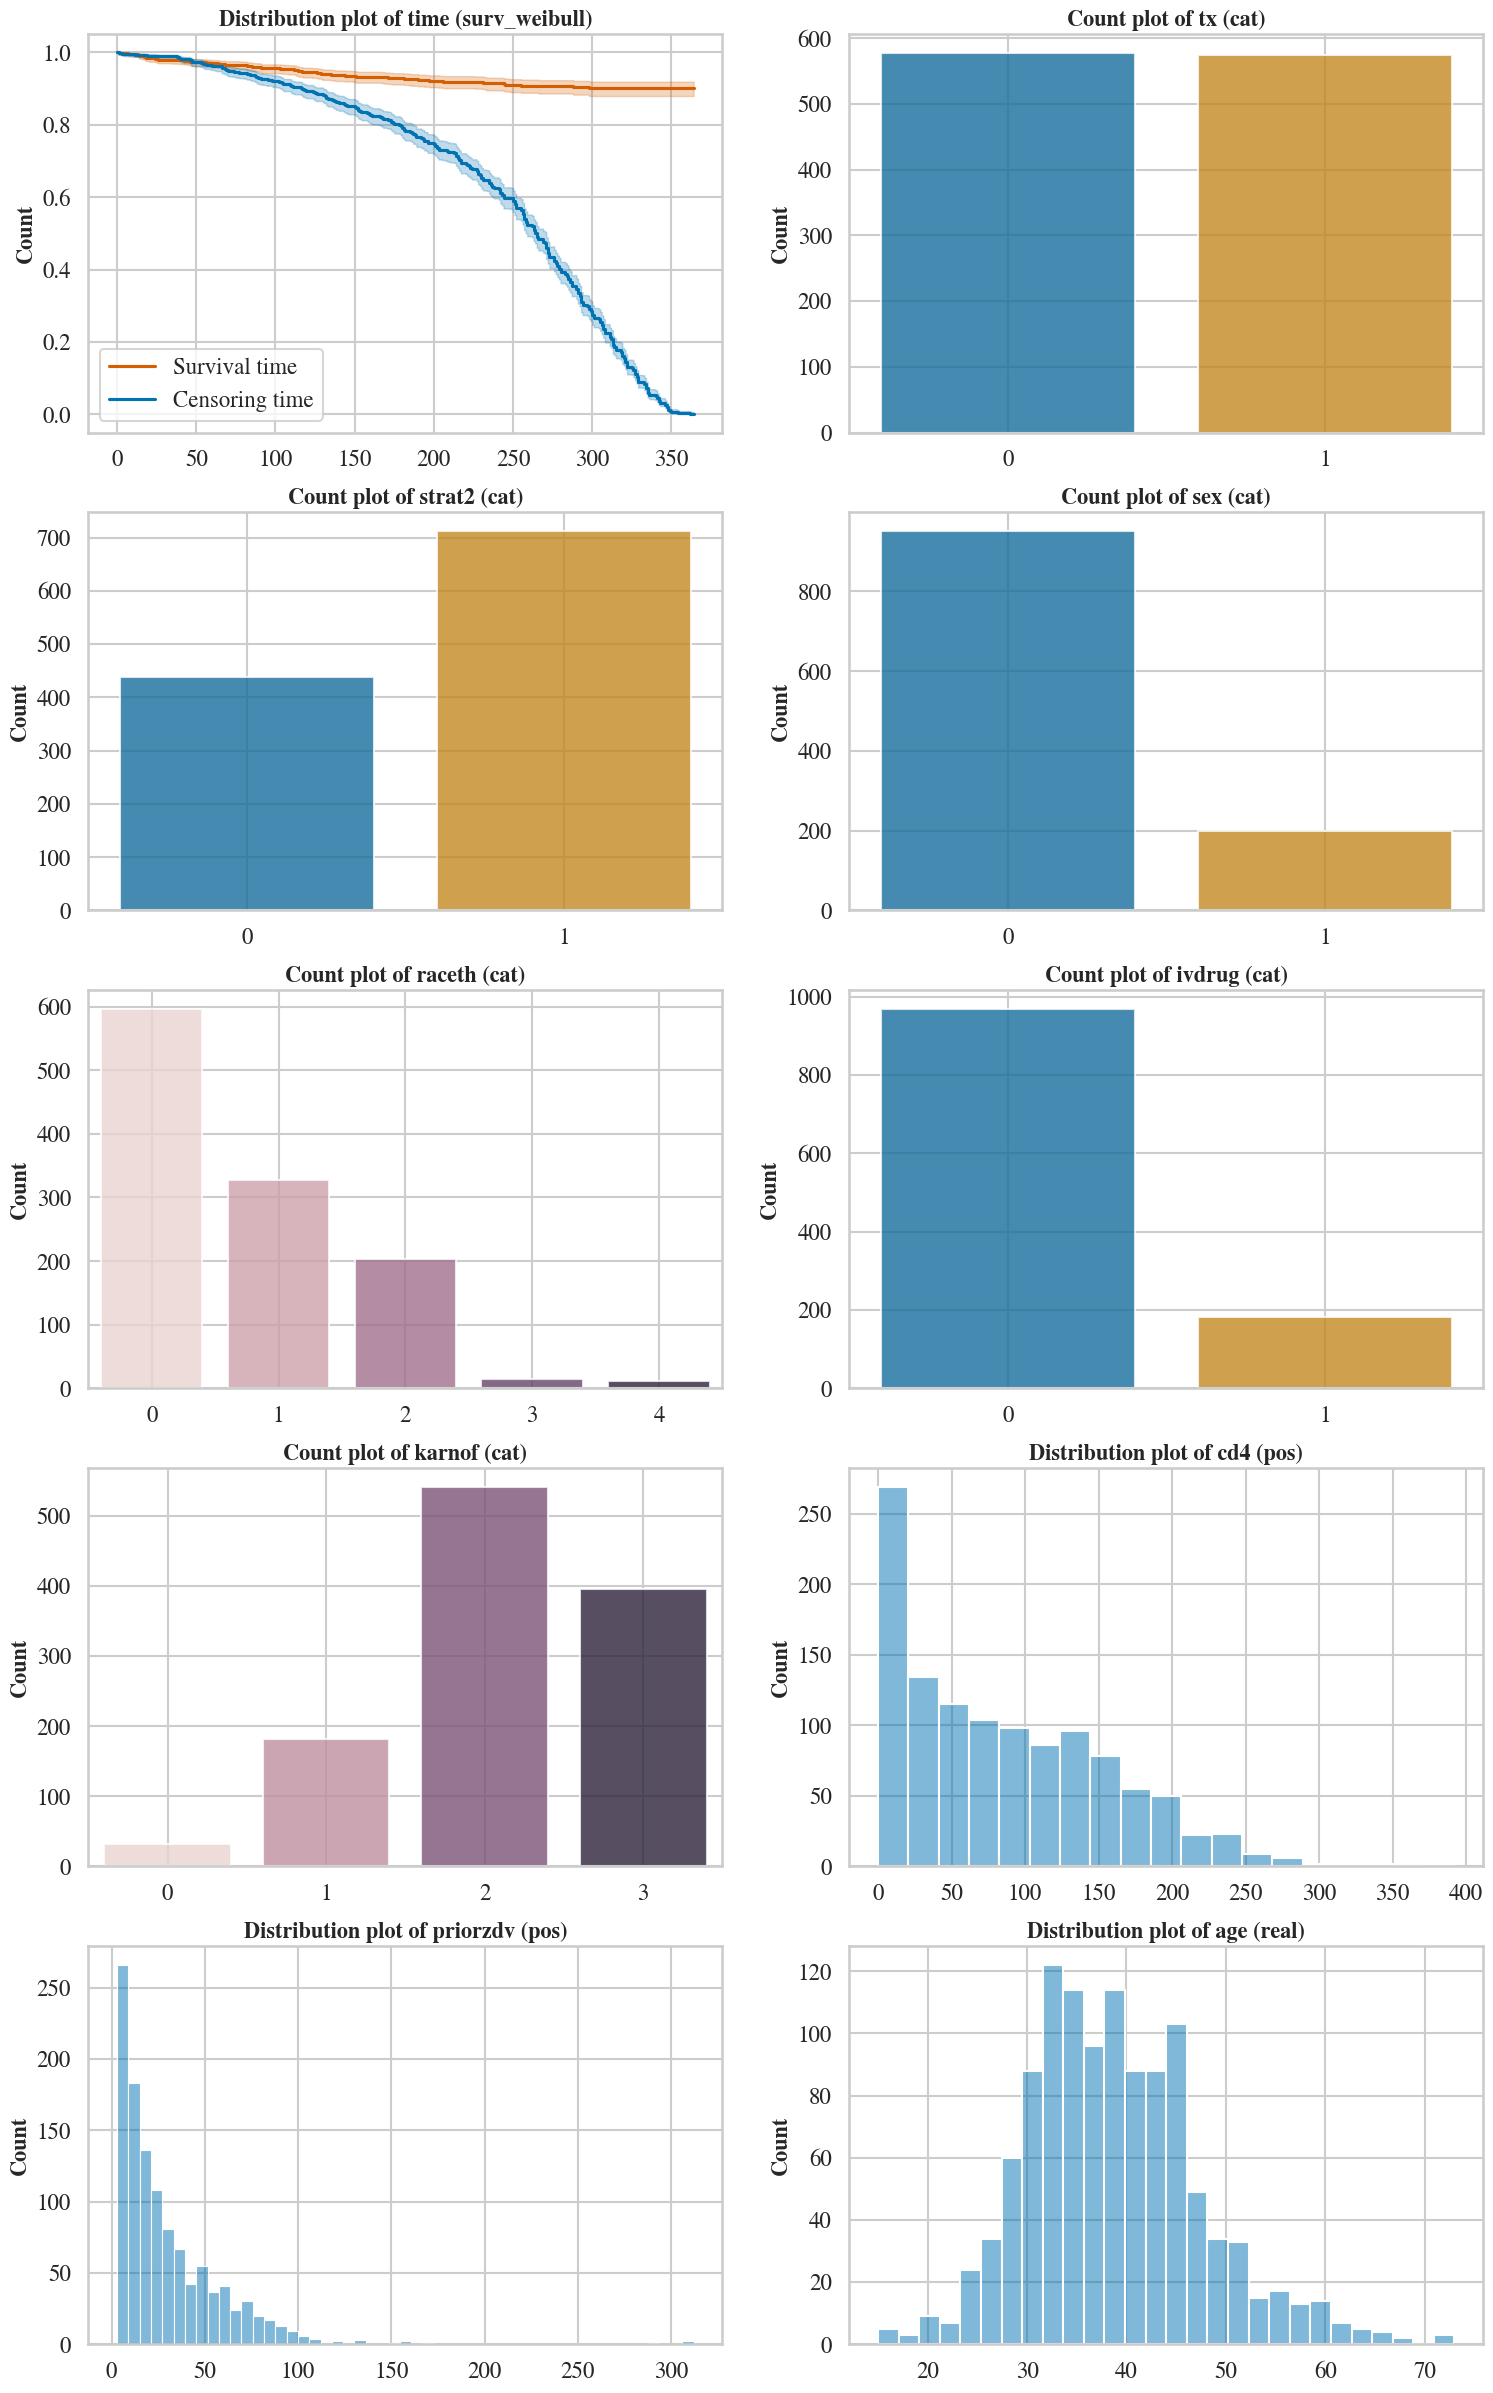

In [5]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed, feat_types_dict,aids.columns)

### Experiment setting

In [6]:
# Train-test split
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

### Model loading

In [7]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 15
dim_latent_y = 10
dim_latent_s = 15
epochs = 500
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [8]:
data.shape

torch.Size([1151, 22])

Epoch: [ 0]  time: 0.0792, ELBO_train: -23.77144184, KL_z: 1.29682595, KL_s: 0.08186376, reconstruction loss: -22.39275213
Epoch: [100]  time: 4.2106, ELBO_train: -19.00628757, KL_z: 0.82202504, KL_s: 0.10925903, reconstruction loss: -18.07500350
Epoch: [200]  time: 7.9566, ELBO_train: -18.86118488, KL_z: 0.91410279, KL_s: 0.11047432, reconstruction loss: -17.83660777
Epoch: [300]  time: 11.6897, ELBO_train: -18.53919506, KL_z: 1.07925947, KL_s: 0.11756976, reconstruction loss: -17.34236584
Epoch: [400]  time: 16.0769, ELBO_train: -18.57399979, KL_z: 1.23059187, KL_s: 0.11831913, reconstruction loss: -17.22508879
Training finished.


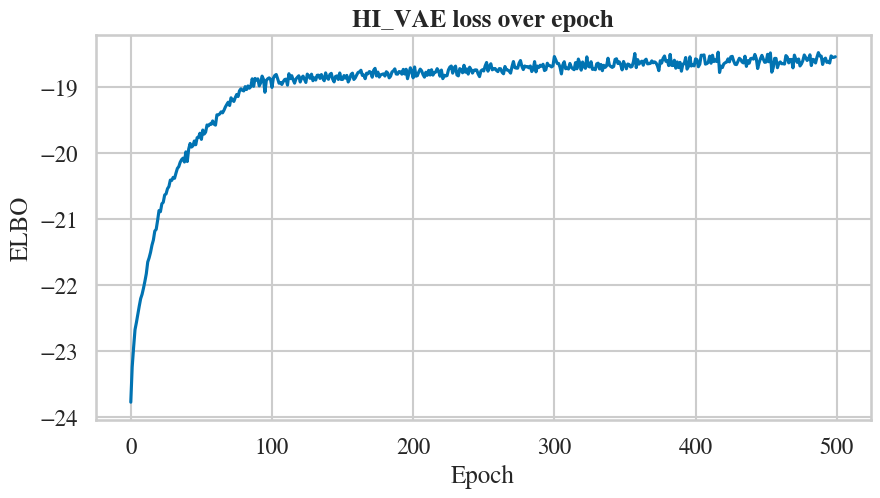

In [9]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)



print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")


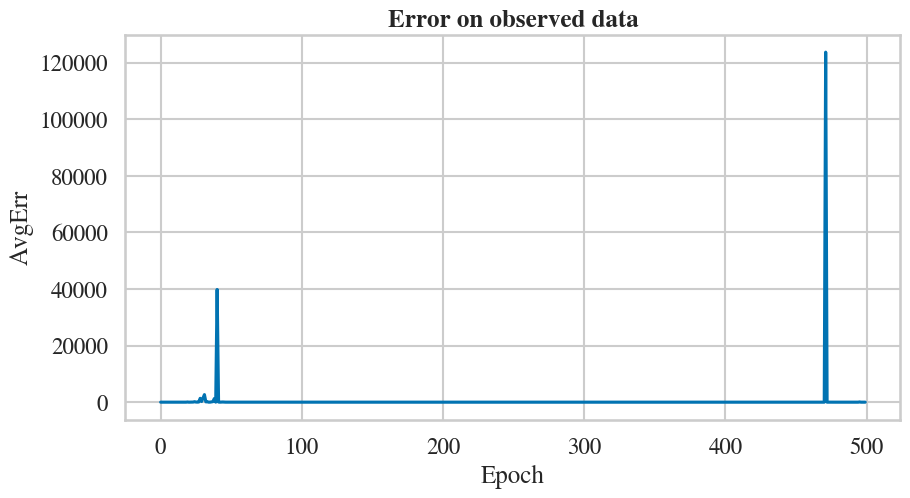

In [10]:
visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

### Test model

In [11]:
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_size = n_test_samples

# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_test):
        data_list, miss_list = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]

        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_test = statistic.samples_concatenation(samples_list)[-1]
    data_test_transformed = data_processing.discrete_variables_transformation(data_test, feat_types_dict)
    est_data_test_transformed = []
    for j in range(n_generated_sample):
        est_data_test_transformed.append(data_processing.discrete_variables_transformation(est_data_test[j], feat_types_dict).unsqueeze(0))
    
    est_data_test_transformed = torch.cat(est_data_test_transformed, dim=0)

### Visualize the generated samples

In [12]:
# Example Usage
torch.manual_seed(42)

true_values = data_test_transformed
# Take first generated sample
idx = 0
estimated_values = est_data_test_transformed[idx]

# Call plotting function
#visualization.plot_true_vs_estimation(true_values, estimated_values, miss_mask_test, feat_types_dict, num_sel_samples=50)


In [13]:
data.shape

torch.Size([1151, 22])

### Statistical analysis with simulated data

In [14]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]


In [15]:
miss_mask_forgen.shape

torch.Size([1151, 10])

In [16]:
data_forgen.shape

torch.Size([1151, 22])

#### Generate from original sample

In [17]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

1151


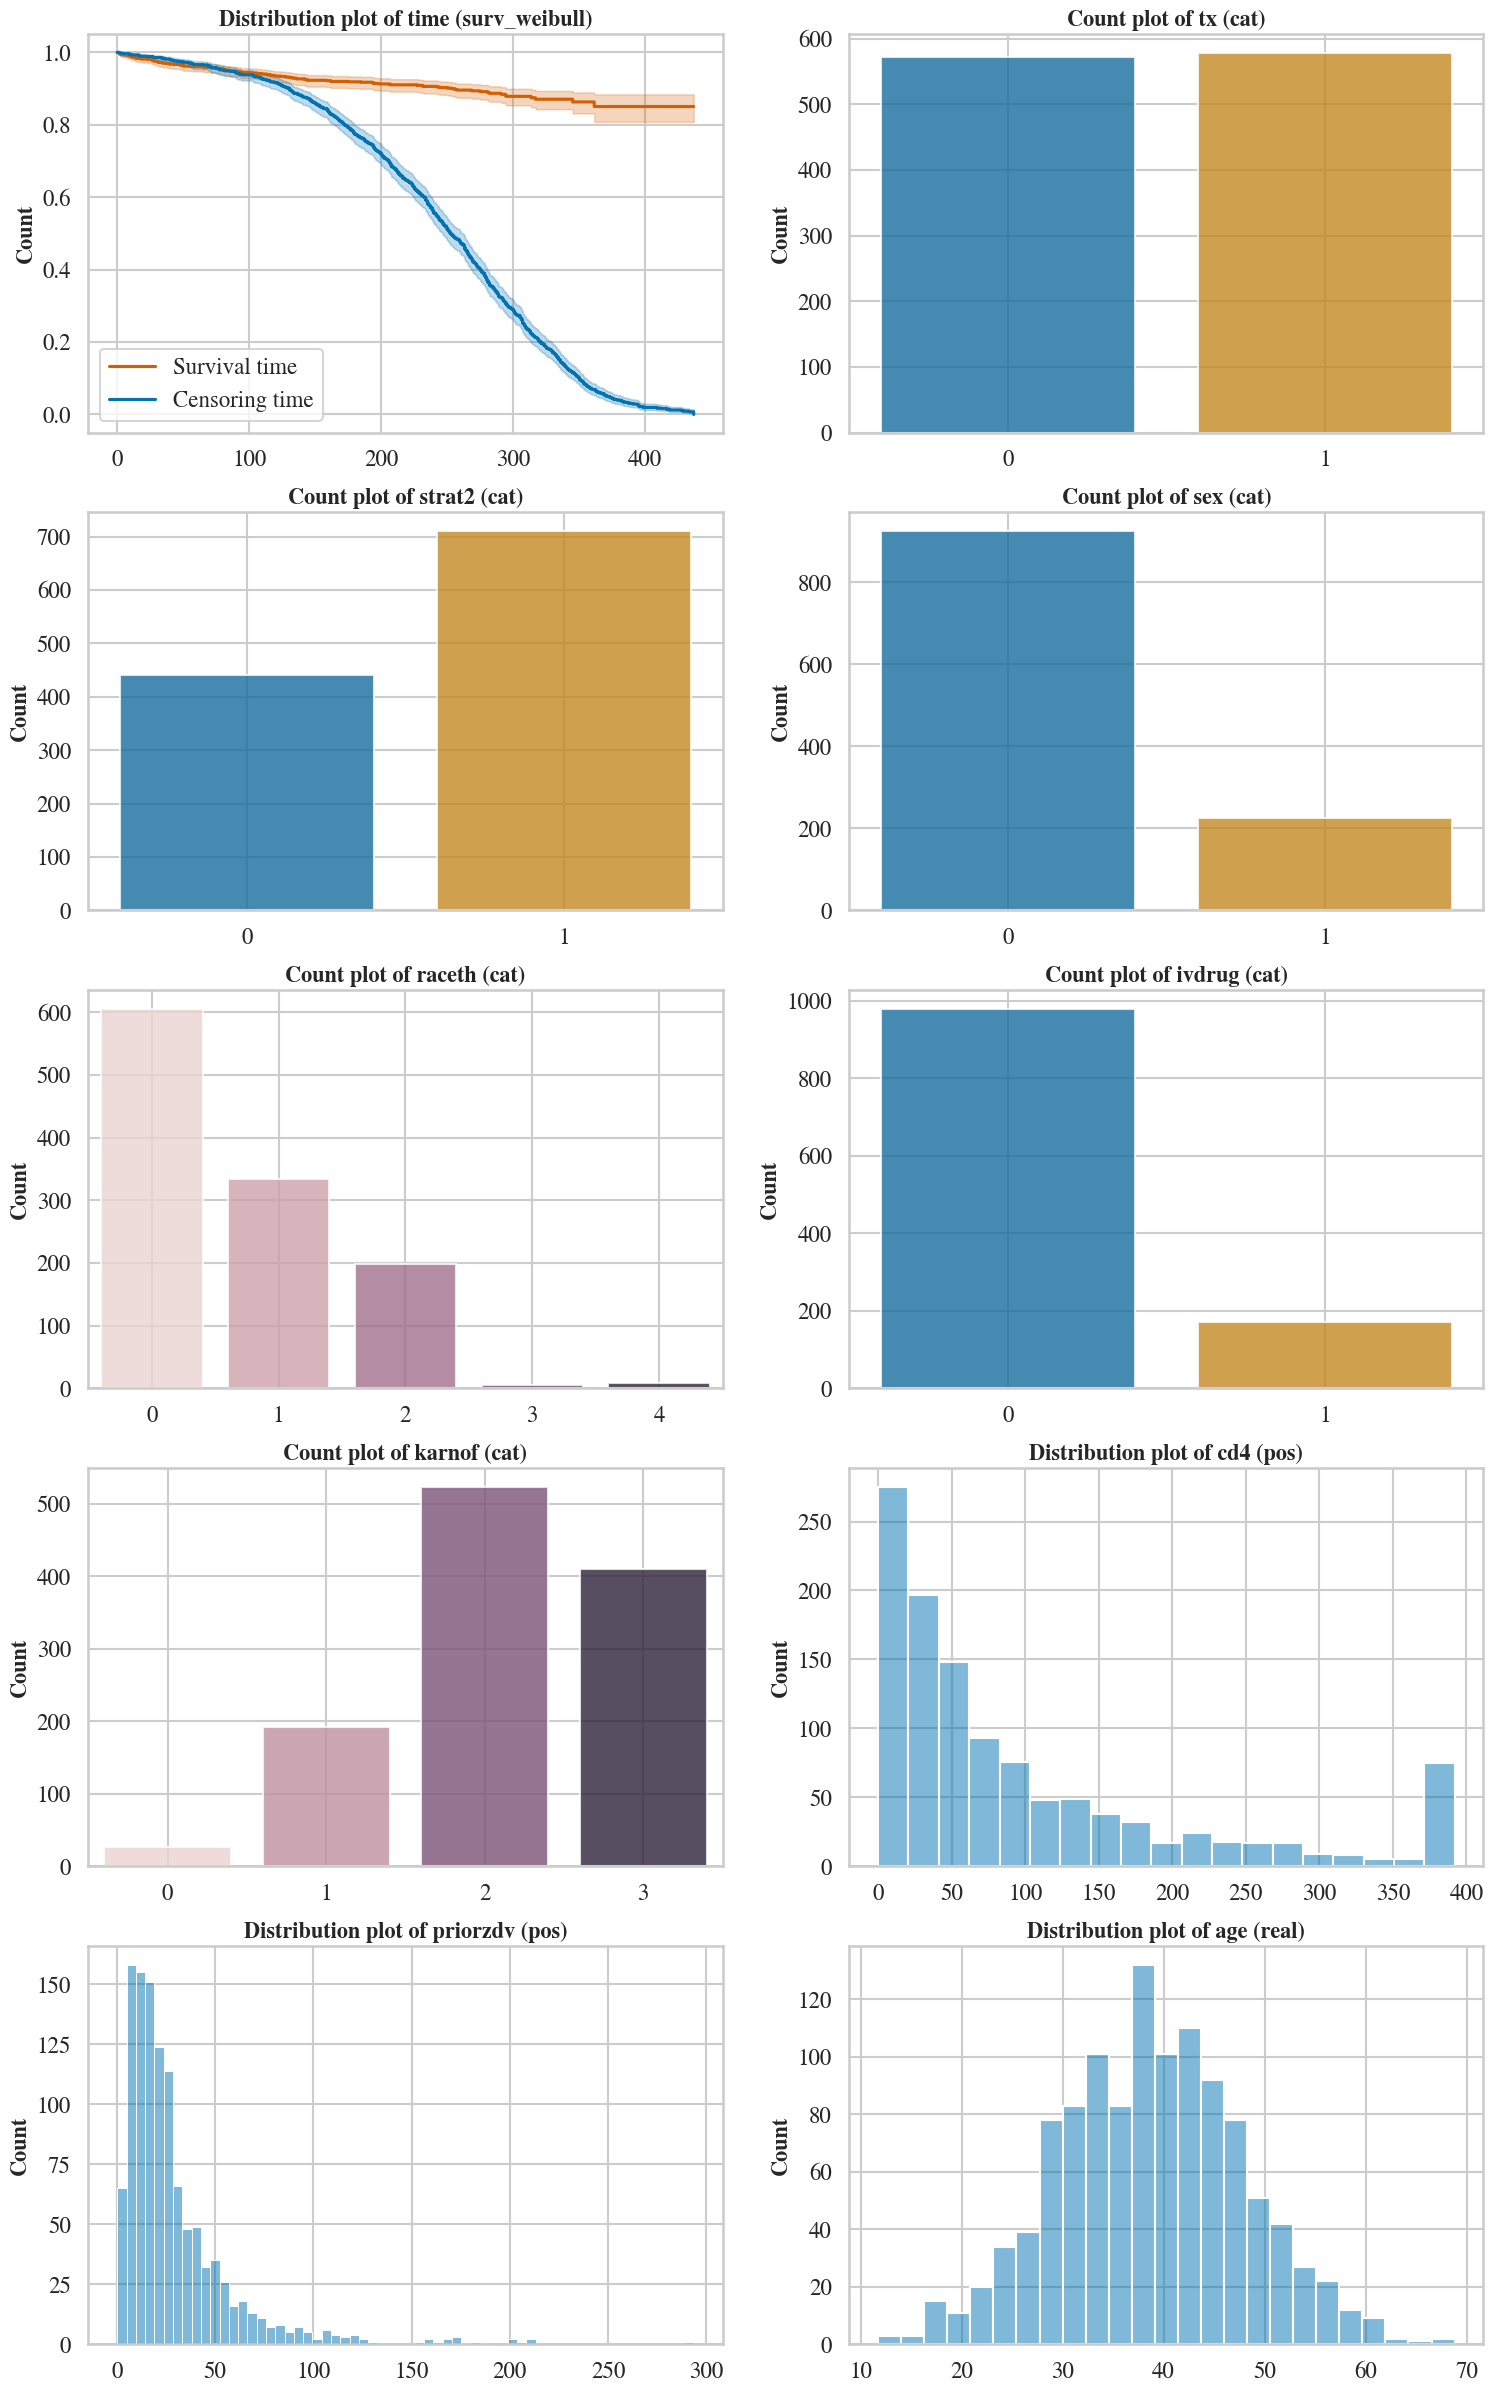

In [18]:
# Call plotting function
visualization.plot_data(est_data_gen_transformed[0], feat_types_dict,aids.columns)

In [42]:
df_transformed_initial = pd.DataFrame(data_transformed.numpy(), columns=aids.columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[1].numpy(), columns=aids.columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_all = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [43]:
df_transformed_all.columns

Index(['time', 'censor', 'tx', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof',
       'cd4', 'priorzdv', 'age', 'sample'],
      dtype='object')

In [44]:
categorical = ['tx','censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [45]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              2302                 1151                 1151        
time, median [Q1,Q3]                         0  249.8 [171.4,299.8]  240.8 [168.7,297.8]  257.0 [174.0,300.0]   0.121
censor, n (%)            0.0                            2086 (90.6)          1031 (89.6)          1055 (91.7)   0.100
                         1.0                              216 (9.4)           120 (10.4)             96 (8.3)        
tx, n (%)                0.0                            1126 (48.9)           549 (47.7)           577 (50.1)   0.260
                         1.0                            1176 (51.1)           602 (52.3)           574 (49.9)        
strat2, n (%)            0.0                            

In [23]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.util import Surv

In [24]:
X_initial = data_transformed.numpy()[:,2:10]
Y_initial = Surv.from_arrays(data_transformed.numpy()[:,1]==1,data_transformed.numpy()[:,0])

In [ ]:
data_transformed.col

In [25]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)


CoxPHSurvivalAnalysis()

In [26]:
coef_initial = np.zeros(cox_initial.coef_.shape[0] + 1)
coef_initial[0] = compare_survival(Y_initial,X_initial[:,0])[1]
coef_initial[1:] = cox_initial.coef_

In [27]:
X_gen = est_data_gen_transformed[0].numpy()[:,2:10]
Y_gen = Surv.from_arrays(est_data_gen_transformed[0].numpy()[:,1]==1,est_data_gen_transformed[0].numpy()[:,0])

In [28]:
print(compare_survival(Y_gen,X_gen[:,0]))

(np.float64(0.3633546700735078), np.float64(0.5466490148756631))


In [29]:
cox_gen = CoxPHSurvivalAnalysis()
cox_gen.fit(X_gen,Y_gen)
cox_gen.coef_

array([-0.11085476, -0.86571266, -0.11169813,  0.06358642,  0.20673924,
        0.18771235,  0.00100003,  0.00219911])

In [30]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    print(i)
    X_gen = est_data_gen_transformed[i].numpy()[:,2:10]
    Y_gen = Surv.from_arrays(est_data_gen_transformed[i].numpy()[:,1]==1,est_data_gen_transformed[i].numpy()[:,0])
    coef_treat[i,0] = compare_survival(Y_gen,X_gen[:,0])[1]
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_gen,Y_gen)
    coef_treat[i,1:] = cox_generated.coef_[:]

0
1
2
3
4
5
6
7
8
9


In [31]:
n_generated_sample

10

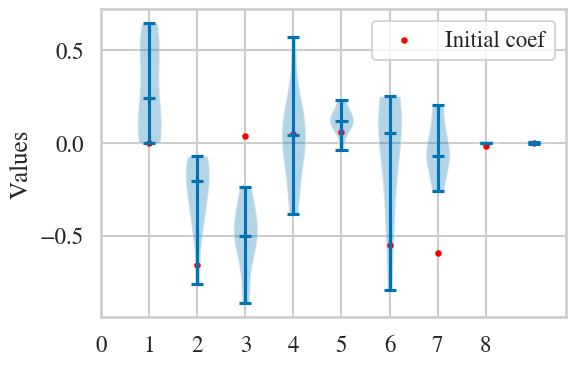

In [32]:


# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1 + np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = coef_initial  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(np.arange(coef_treat.shape[1]))
#ax.set_xticklabels()
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [33]:
cox_generated.coef_

array([-7.62162642e-01, -2.38327829e-01,  1.37030414e-01,  1.36027168e-01,
       -3.28952619e-01, -2.60859715e-01, -2.22785371e-03, -1.83086078e-04])

In [34]:
cox_initial.coef_

array([-6.59630151e-01,  3.63547003e-02,  4.93010818e-02,  5.89317929e-02,
       -5.51108489e-01, -5.96533517e-01, -1.42261606e-02,  1.93656275e-04])

In [36]:
coef_treat

array([[ 5.46649015e-01, -1.10854761e-01, -8.65712655e-01,
        -1.11698132e-01,  6.35864184e-02,  2.06739237e-01,
         1.87712354e-01,  1.00003251e-03,  2.19910707e-03],
       [ 8.60008538e-03, -4.51666112e-01, -5.30985908e-01,
         4.48604834e-02,  1.09345021e-01,  9.91309977e-02,
         7.45617347e-02, -1.85511486e-03, -3.81143422e-03],
       [ 4.08415234e-02, -4.18684899e-01, -4.55578131e-01,
         1.85582875e-01, -3.91405532e-02, -3.76922282e-02,
        -2.47456166e-01,  2.63216803e-04,  2.87895026e-03],
       [ 8.87407436e-02, -3.03925291e-01, -4.96200338e-01,
         3.68091814e-02,  1.98506531e-01,  2.52536485e-01,
         2.03042776e-01, -7.83589435e-04,  4.77173149e-03],
       [ 4.80540591e-01, -1.14188600e-01, -3.08064988e-01,
         5.71664033e-01,  1.51824338e-01, -4.28839814e-01,
        -7.69436075e-02, -1.19308790e-03, -1.85492068e-04],
       [ 2.82477190e-01, -1.70003873e-01, -7.67492771e-01,
        -3.81152479e-01,  8.59048523e-02,  1.239714

In [37]:
coef_initial

array([ 1.16508626e-03, -6.59630151e-01,  3.63547003e-02,  4.93010818e-02,
        5.89317929e-02, -5.51108489e-01, -5.96533517e-01, -1.42261606e-02,
        1.93656275e-04])